In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

# 1. Dataset Introduction & Loading

The `quality_control` dataset is a real world sensor time series from [NASA Anomaly Detection Dataset SMAP & MSL](https://www.kaggle.com/datasets/patrickfleith/nasa-anomaly-detection-dataset-smap-msl?resource=download). The data subset of `P-2` tracks NASA's Soil Moisture Active Passive (SMAP), and is used for the following analyses. 

This dataset serves as the quality control domain case study in this project. It is broken down into a training and test set, with the training dataset containing no anomalies and labeled anomalies in the test set. 

Quality control time series are valuable in anomaly detection research for several reasons:


### Basic Information
- **Granularity:** Sequentially indexed
- **Length:** 2821 records (train), 8209 records (test)
- **Anomalies:** `[[5350, 6575]]`
- **Features:** Multivariate (25 features), Binary features, Labeled anomalies

## Loading the Dataset

In [17]:
import pandas as pd
import numpy as np

train = pd.DataFrame(np.load('../data/quality_control/train.npy'))
test = pd.DataFrame(np.load('../data/quality_control/test.npy'))

train.describe().T

,count,mean,std,min,25%,50%,75%,max
0,2821.0,-0.943302,0.028377,-1.0,-0.96889,-0.955556,-0.915556,-0.84
1,2821.0,0.037575,0.190201,0.0,0.00000,0.000000,0.000000,1.00
2,2821.0,0.007444,0.085973,0.0,0.00000,0.000000,0.000000,1.00
3,2821.0,0.029777,0.170001,0.0,0.00000,0.000000,0.000000,1.00
4,2821.0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.00
5,2821.0,0.169089,0.374897,0.0,0.00000,0.000000,0.000000,1.00
6,2821.0,0.129032,0.335295,0.0,0.00000,0.000000,0.000000,1.00
7,2821.0,0.001418,0.037635,0.0,0.00000,0.000000,0.000000,1.00
8,2821.0,0.000709,0.026622,0.0,0.00000,0.000000,0.000000,1.00
9,2821.0,0.000709,0.026622,0.0,0.00000,0.000000,0.000000,1.00


The test data is plotted below to give a sense of what the anomalies `[5350, 6575]` look like

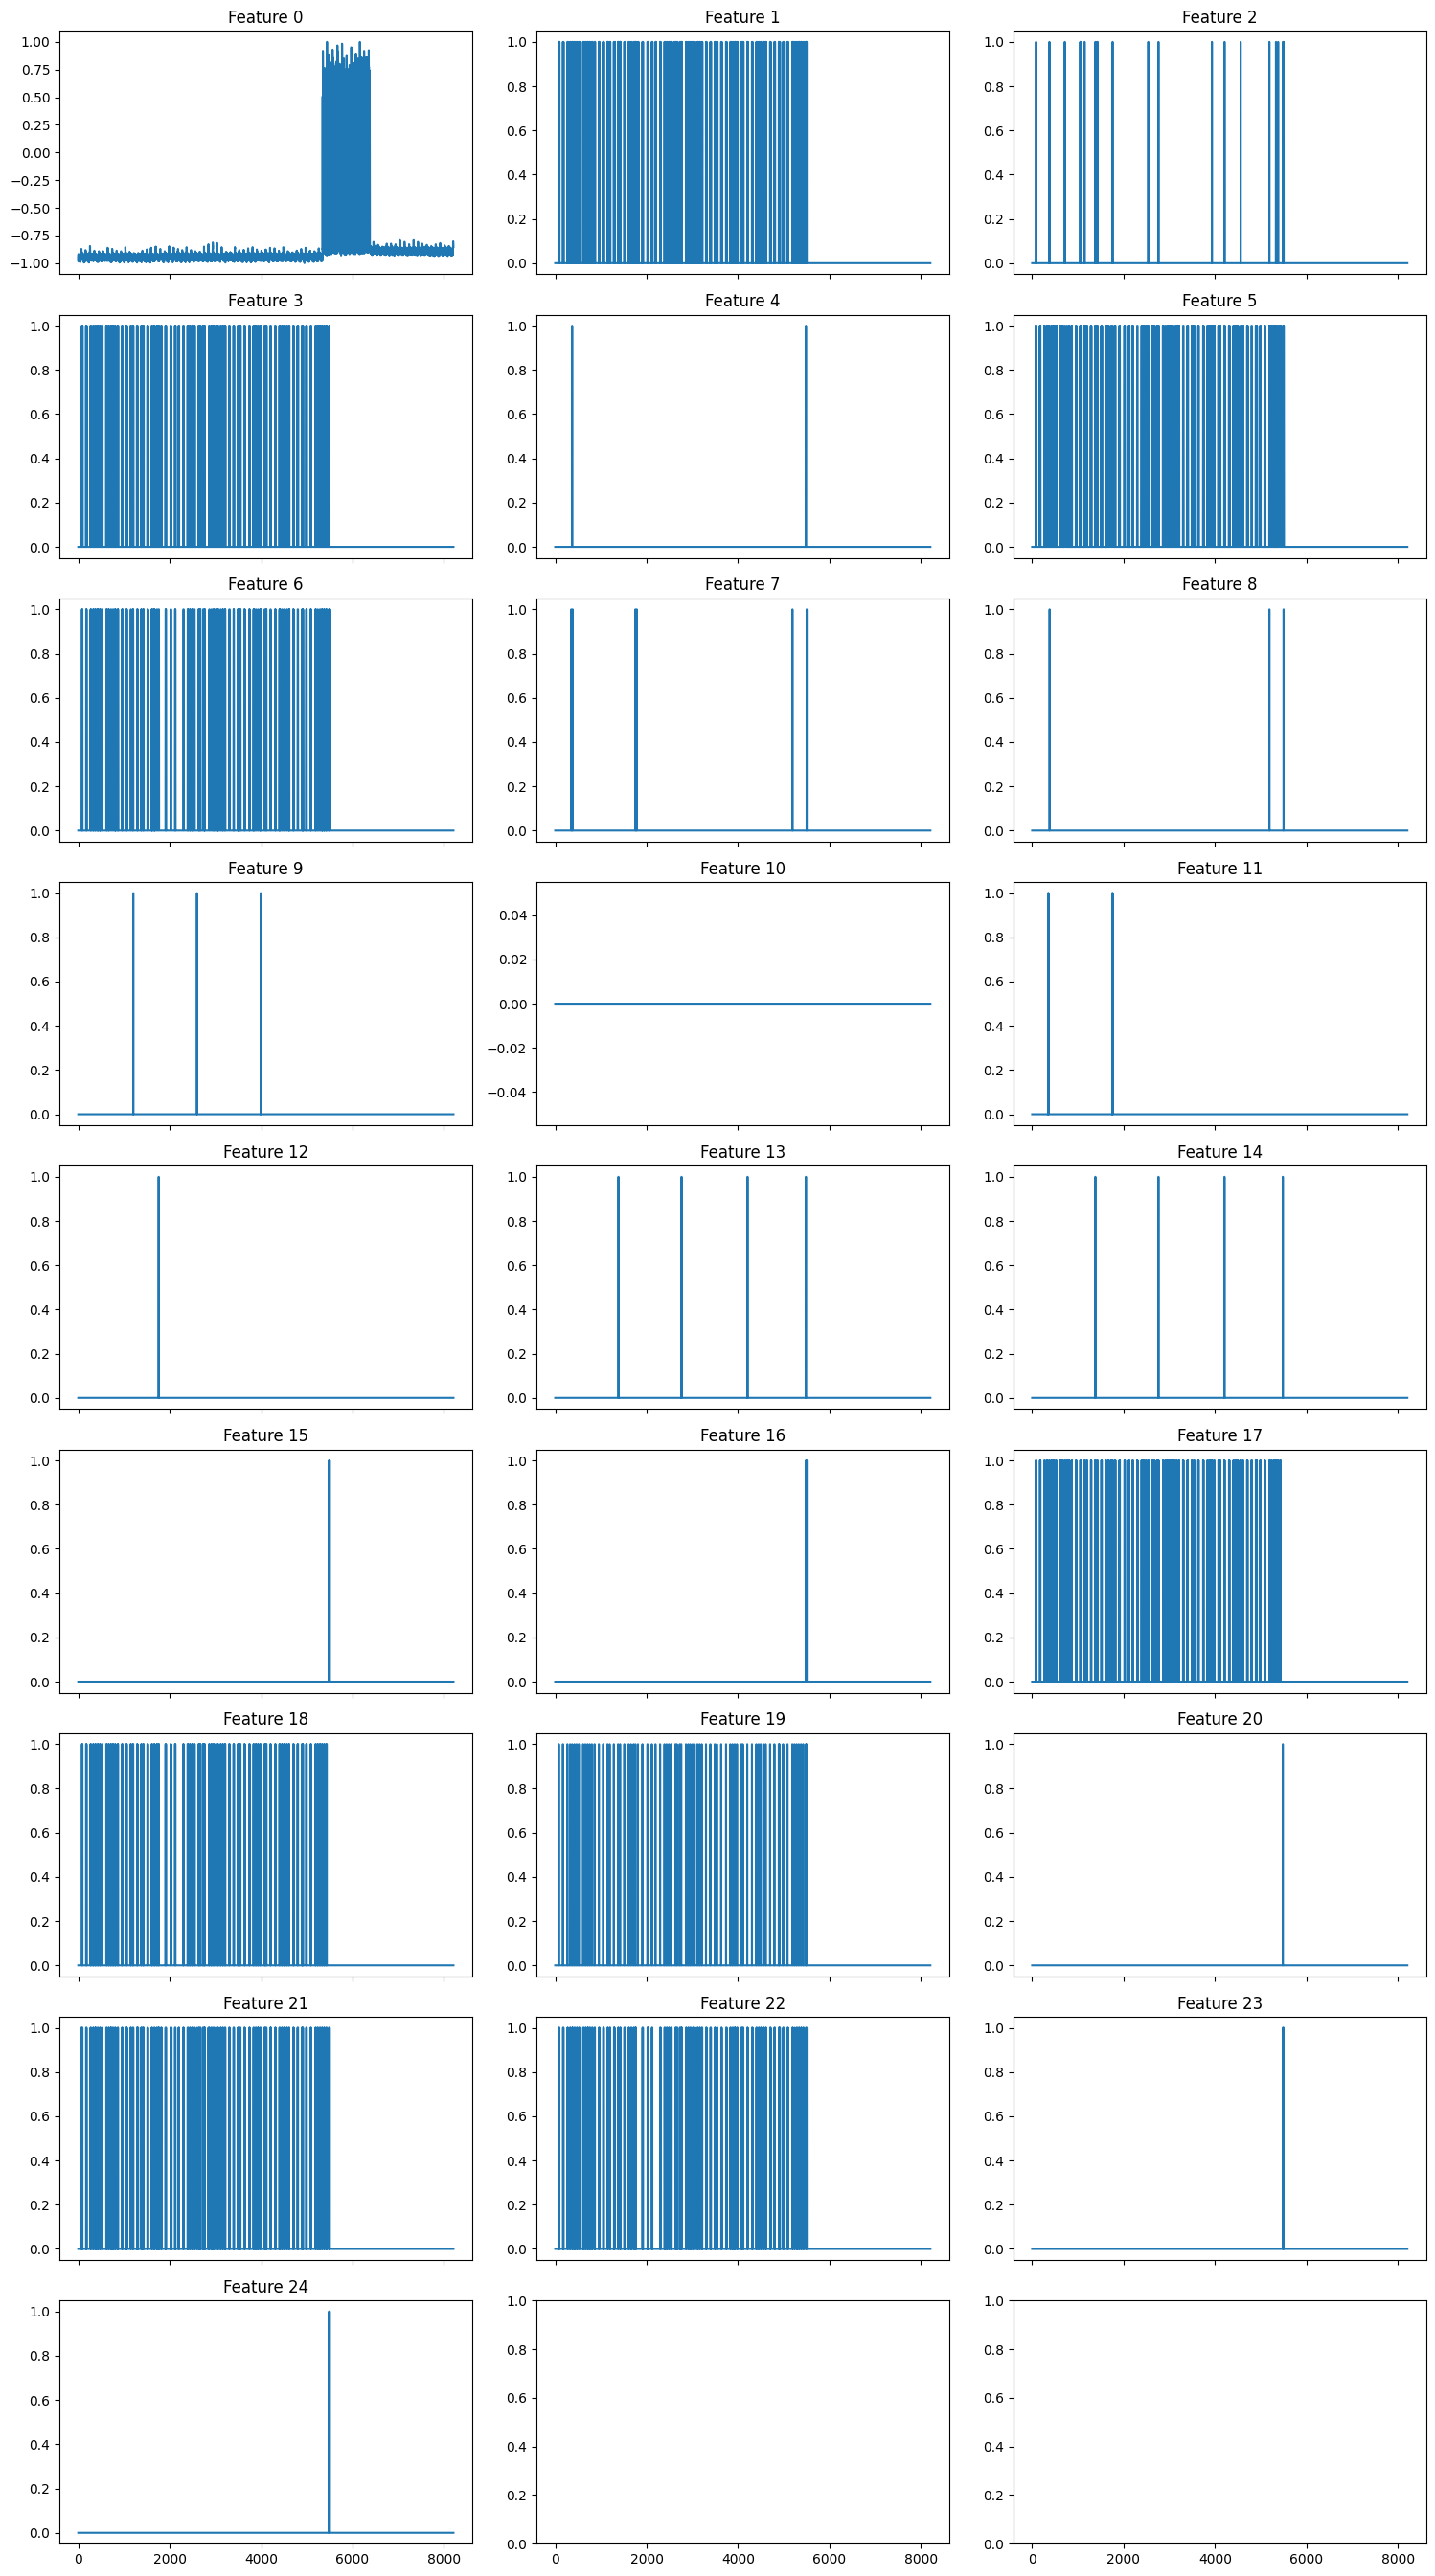

In [18]:
from src.visualization.plots import plot_multi_variate

plot_multi_variate(test)

## Exploratory Analysis

The output of `train.describe().T` reveals that several columns have a standard deviation of `0`, indicating constant features. These columns were removed from the training set to streamline analysis and avoid unnecessary computation.

All remaining non-constant features were then plotted to provide an initial view of the dataset’s structure and distribution.

(2821, 18)


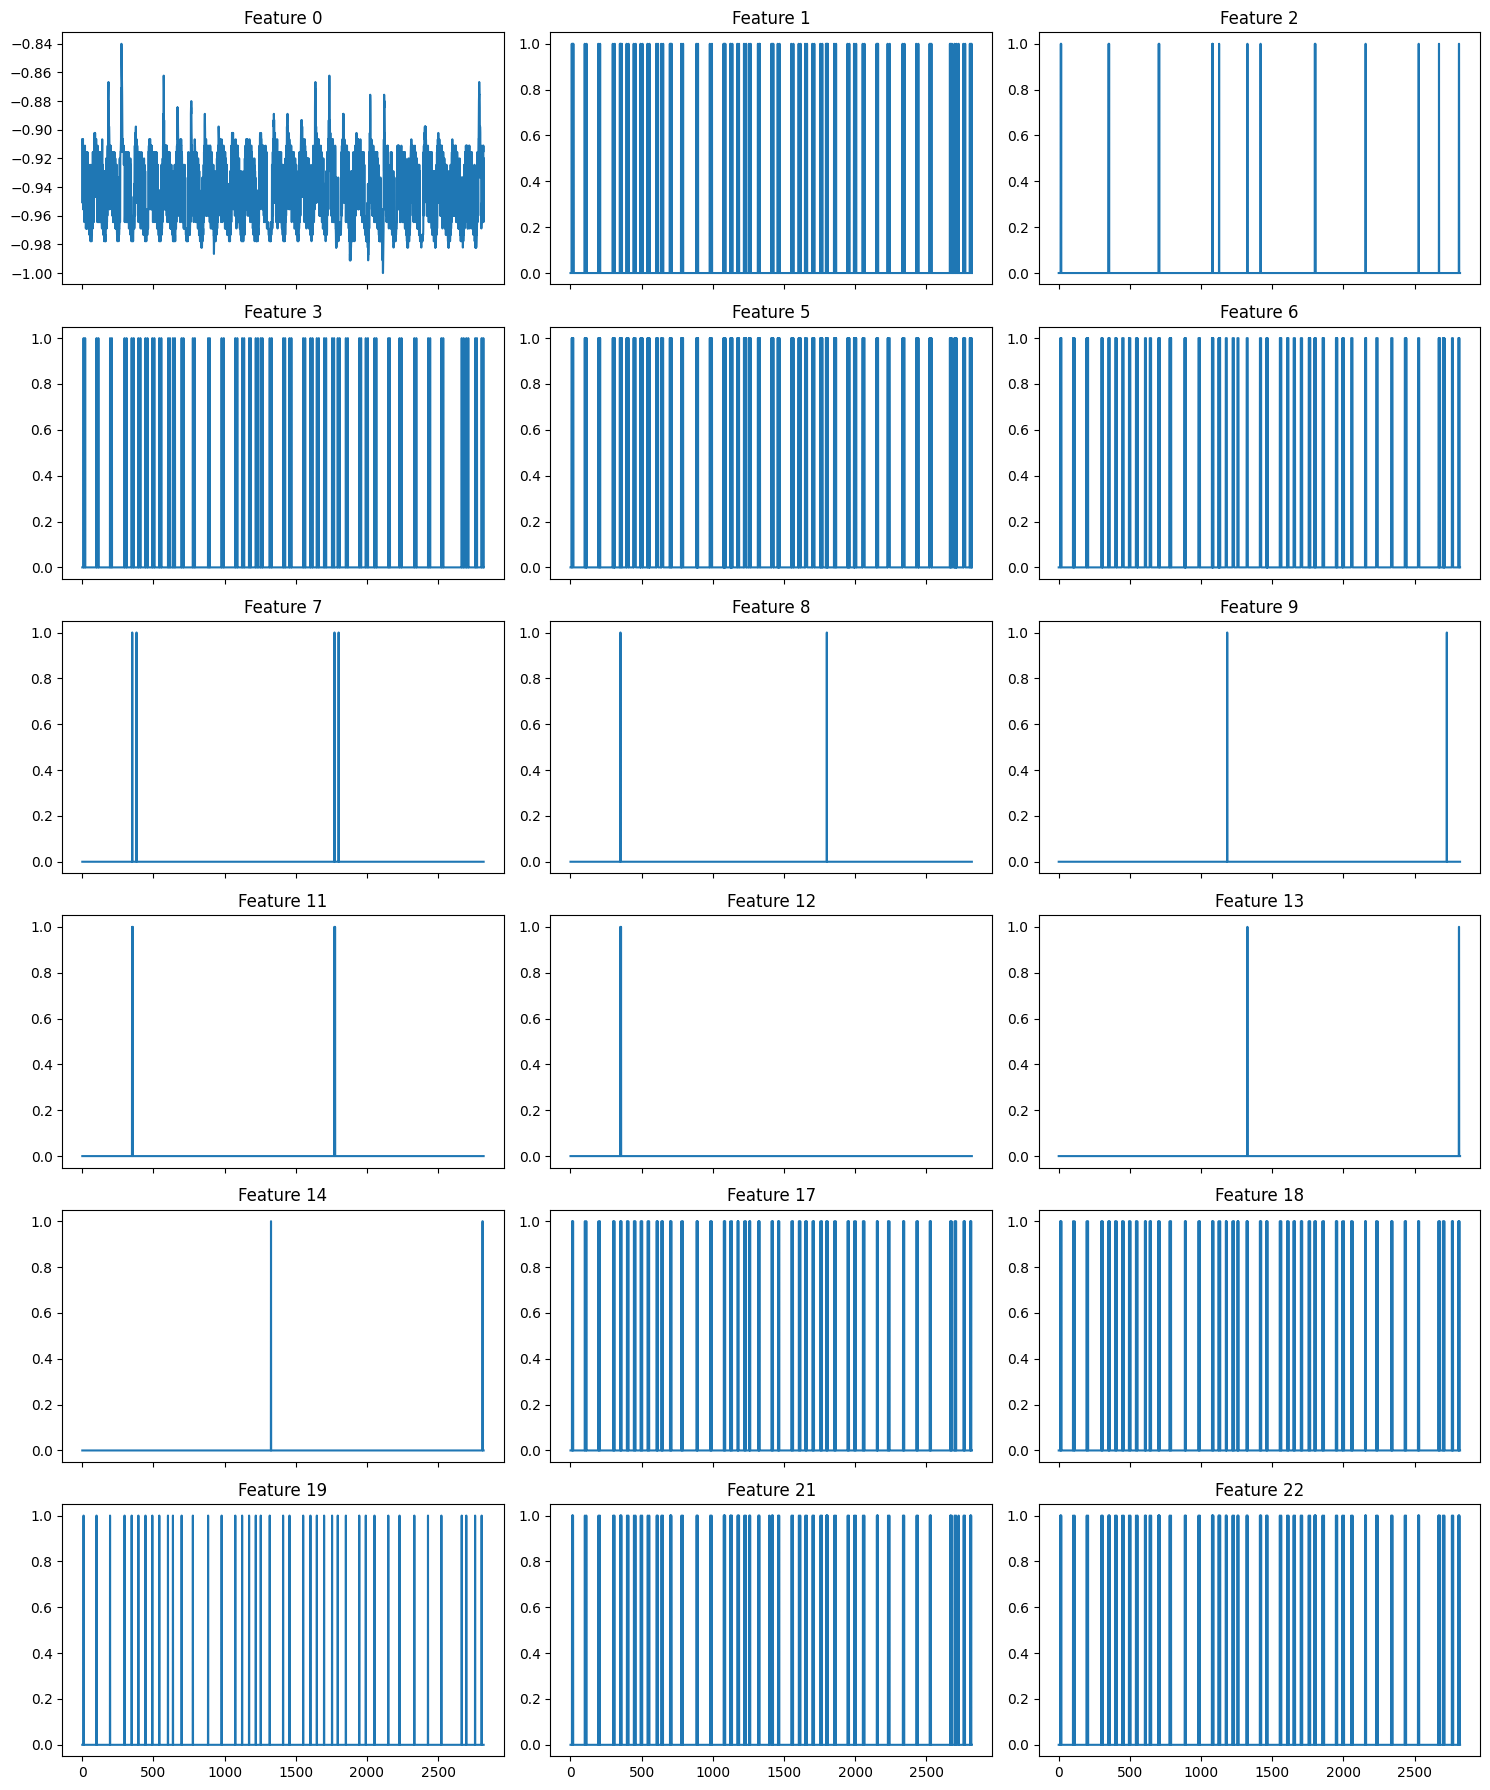

In [19]:
from src.visualization.plots import plot_multi_variate

constant_features = train.columns[train.std() == 0]
df = train.loc[:, train.std() != 0]

print(df.shape)
plot_multi_variate(df)

The plots above indicate that, with the exception of `feature 0`, all features appear to be binary. This observation is confirmed by the subsequent code analysis.

In [20]:
unique_vals = df.nunique()
binary_cols = unique_vals[unique_vals <= 2].index.tolist()

print(f'{len(binary_cols)} binary columns found: {binary_cols}')

17 binary columns found: [1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 21, 22]


### Binary Feature Compression

Working with 17 distinct binary columns can be cumbersome, motivating an exploration of their interrelationships to determine whether they can be compressed into a smaller set of features.  

The correlation heatmap below illustrates the relationships among these 17 binary features.

<Axes: >

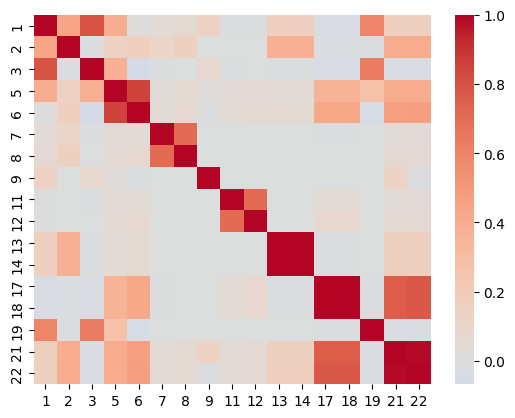

In [21]:
import seaborn as sns

corr = df.iloc[:, 1:].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)


The graph indicates a few strongly correlated features (like 13 with 14 and 17 with 18), however, most features have very low correlation with each other, indicating that the information is not redundant and compression might not be the most ideal take

None the less, a PCA compression is preformed below in attempt to compress the 17 binary feature into 3 PCA features. 

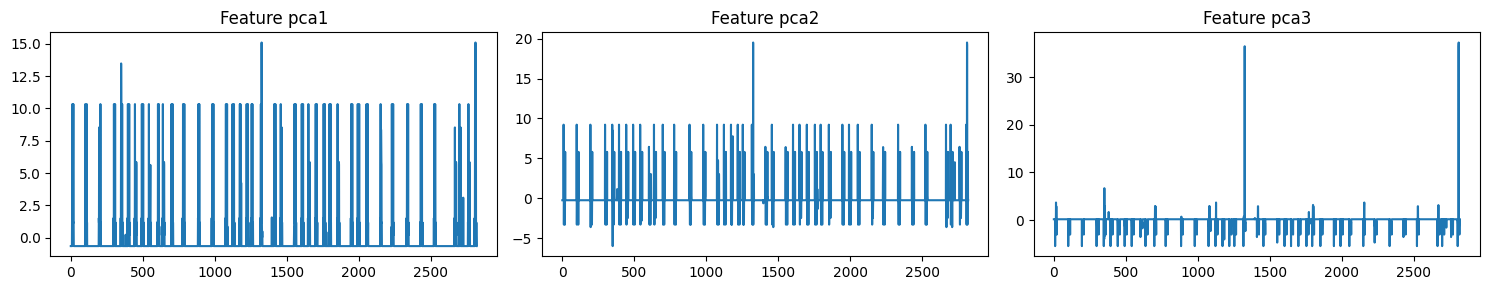

,count,mean,std,min,25%,50%,75%,max
0,2821.0,-9.433018e-01,0.028377,-1.000000,-0.968890,-0.955556,-0.915556,-0.840000
1,2821.0,3.757533e-02,0.190201,0.000000,0.000000,0.000000,0.000000,1.000000
2,2821.0,7.444169e-03,0.085973,0.000000,0.000000,0.000000,0.000000,1.000000
3,2821.0,2.977667e-02,0.170001,0.000000,0.000000,0.000000,0.000000,1.000000
5,2821.0,1.690890e-01,0.374897,0.000000,0.000000,0.000000,0.000000,1.000000
6,2821.0,1.290323e-01,0.335295,0.000000,0.000000,0.000000,0.000000,1.000000
7,2821.0,1.417937e-03,0.037635,0.000000,0.000000,0.000000,0.000000,1.000000
8,2821.0,7.089685e-04,0.026622,0.000000,0.000000,0.000000,0.000000,1.000000
9,2821.0,7.089685e-04,0.026622,0.000000,0.000000,0.000000,0.000000,1.000000
11,2821.0,1.417937e-03,0.037635,0.000000,0.000000,0.000000,0.000000,1.000000


In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA(n_components=3)

scaled_data = scaler.fit_transform(df.iloc[:, 1:18])
pca_result = pca.fit_transform(scaled_data)
df.loc[:, ['pca1', 'pca2', 'pca3']] = pca_result

plot_multi_variate(df[['pca1', 'pca2', 'pca3']])
df.describe().T

The same PCA transformation is preformed on the test set for easy evaluation. 

In [23]:
scaled_test = scaler.transform(test.loc[:, df.columns[1:18]])
test.loc[:, ['pca1', 'pca2', 'pca3']] = pca.transform(scaled_test)

# 2.  Classical Statistical Methods

## Multivariate Normal

The multivariate normal (MVN) distribution is a natural fit for PCAs with continuous, linearly related variables and works best when data follow an approximately Gaussian distribution. 

In this case however, most features of the dataset are binary, making it not ideal for MVN models. None the less, MVN is model to investigate how it haves on datasets with binary features.


Minimum training score: -408.4699414421761
First Percentile cutoff: -25.29245696151591


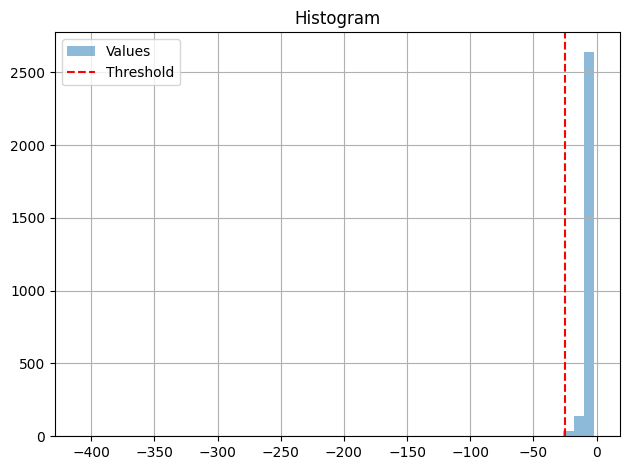

In [10]:
from src.models.statistical.linear_models import mvn_model
from src.visualization.plots import plot_hist

mvn = mvn_model(df[[0, 'pca1', 'pca2', 'pca3']])
train_scores_mvn = mvn.logpdf(df[[0, 'pca1', 'pca2', 'pca3']].values)
cutoff_mvn = np.percentile(train_scores_mvn, 1)

print(f'Minimum training score: {min(train_scores_mvn)}')
print(f'First Percentile cutoff: {cutoff_mvn}')
plot_hist(train_scores_mvn, threshold=cutoff_mvn)

### Evaluation

Since the training data contains no anomalies, the first percentile of the training data used as the cutoff value for the test data

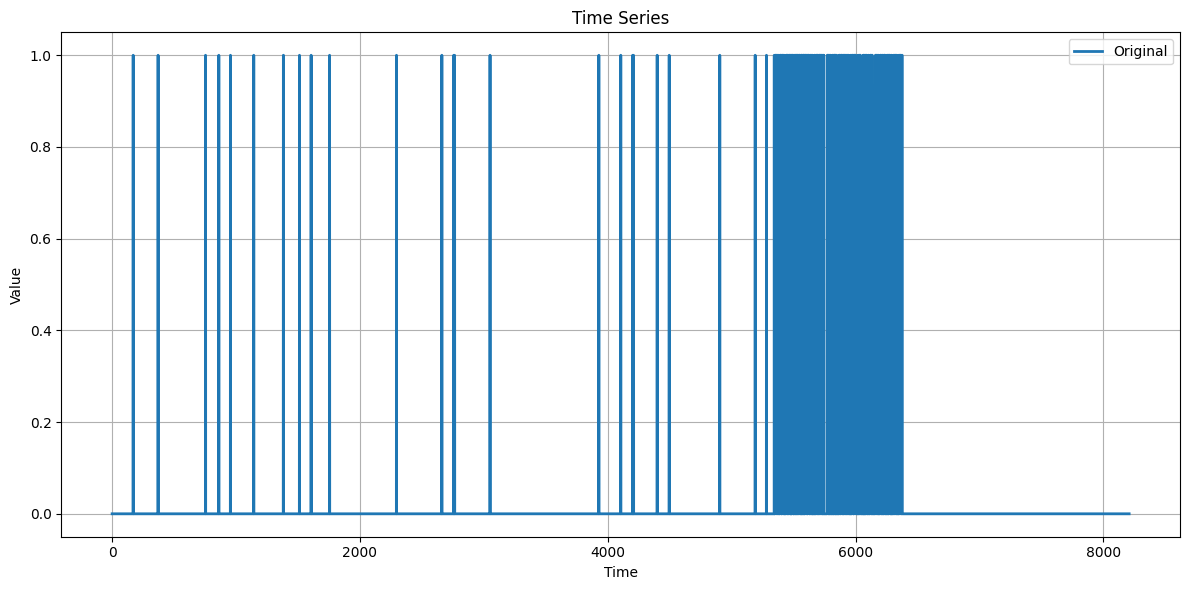

In [ ]:
from src.visualization.plots import plot_ts

test_scores_mvn = mvn.logpdf(test[[0, 'pca1', 'pca2', 'pca3']].values)
mvn_anom = test_scores_mvn < cutoff_mvn

plot_ts(mvn_anom, title="Anomalies by MVN cutoff")

The graph shows that most anomalies in the range `[5350, 6575]` are correctly detected, with some false positives scattered within `[0, 5350]`.  

The model performs surprisingly well despite the data not following a multivariate normal distribution. A likely explanation is that the continuous feature (`feature 0`) carries the most discriminative information for identifying anomalies, allowing the model to make accurate predictions even when distributional assumptions are not strictly met.

## CUSUM on Continuos feature

CUSUM (Cumulative Sum Control Chart) is commonly used in quality control as is highly sensitive to small, persistent shifts in a process mean—changes. By cumulatively summing deviations from a target value, CUSUM can detect gradual drifts and sustained process changes early, enabling timely corrective action. 

For this dataset, CUSUM is applied to the continuous feature (`feature 0`) to identify anomalies. 


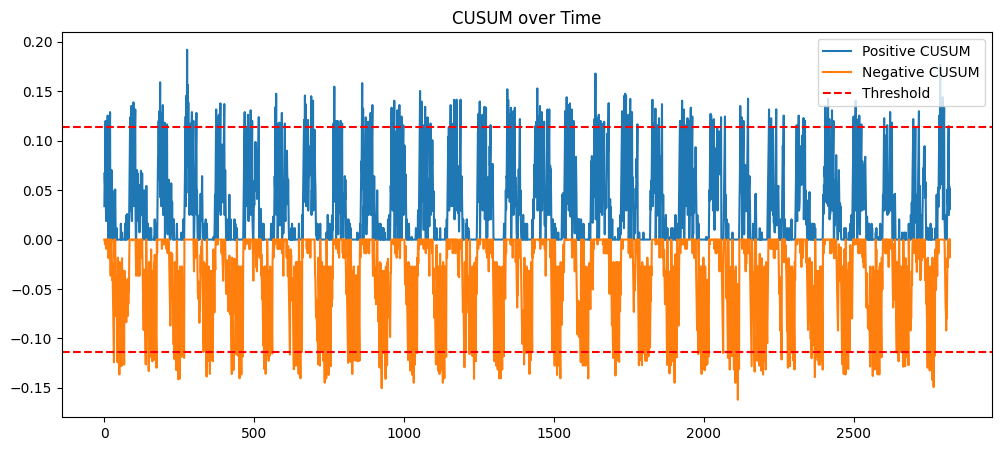

In [12]:
from src.models.statistical.rule_based import cusum

_ = cusum(df[0], plot=True)

The continuous variable for the training data has `mean=0` with almost all CUSUMs in `[-0.15, 0.15]`.

### Evaluation

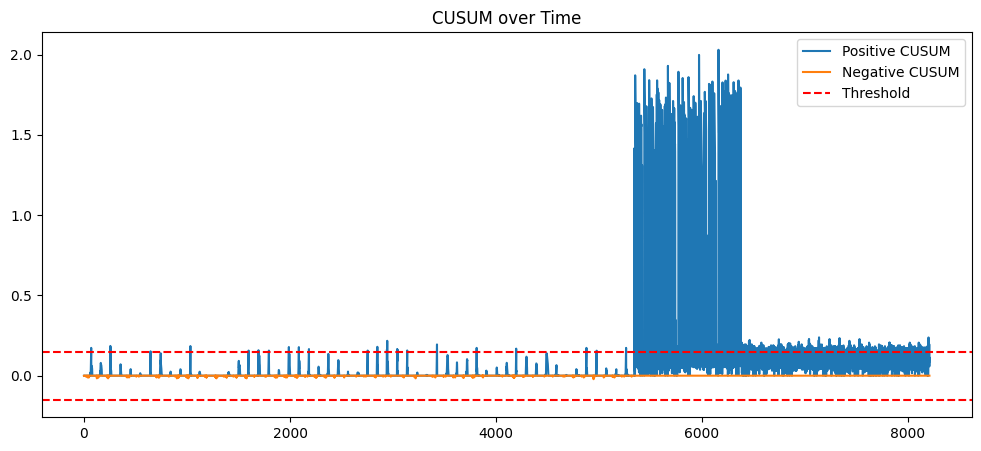

In [13]:
cusum_result = cusum(test[0], mean=df[0].mean(), threshold=0.15, plot=True)

The CUSUM model successfully identifies most anomalies in the range `[5350, 6575]`, with some false positive outside the range.

## BOCPD on Continuous feature

Bayesian Online Change Point Detection (BOCPD) used for quality control as it identifies shifts in the statistical properties of a process in real time. BOCPD can detect sudden changes in mean, variance, or other distributional parameters without needing fixed thresholds. This probabilistic approach makes it robust to noise and adaptable to non-stationary processes, providing both rapid detection of true shifts and reduced false alarms.

For this dataset, BOCPD is applied to the continuous feature (`feature 0`) to identify anomalies. 


Use scipy logsumexp().


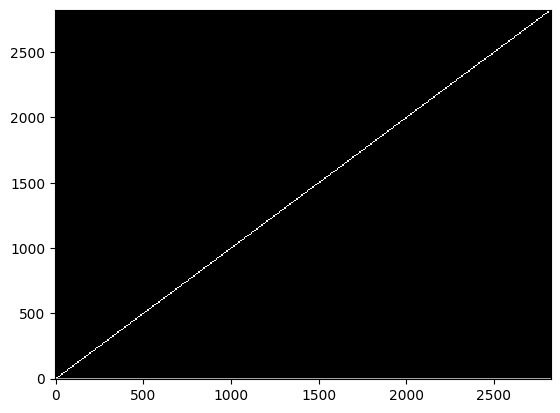

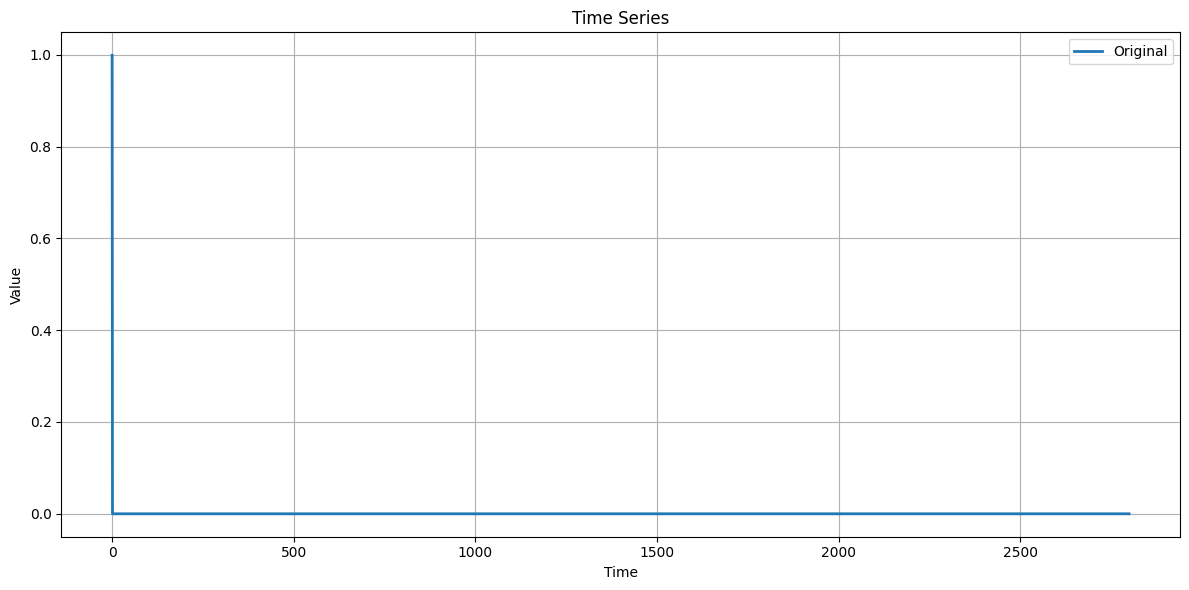

In [14]:
from functools import partial
from bayesian_changepoint_detection.hazard_functions import constant_hazard
from src.models.statistical.bayesian_models import bocpd

hazard_function = partial(constant_hazard, 1000)
bocpd(df[0], hazard_function, sparsity=10, Nw=20)



Applying BOCPD to the training data yields no identified anomalies, which is as expected since there are no anomalies in the training dataset.

### Evaluation

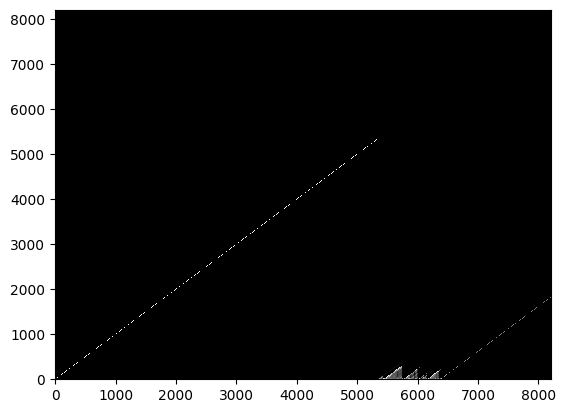

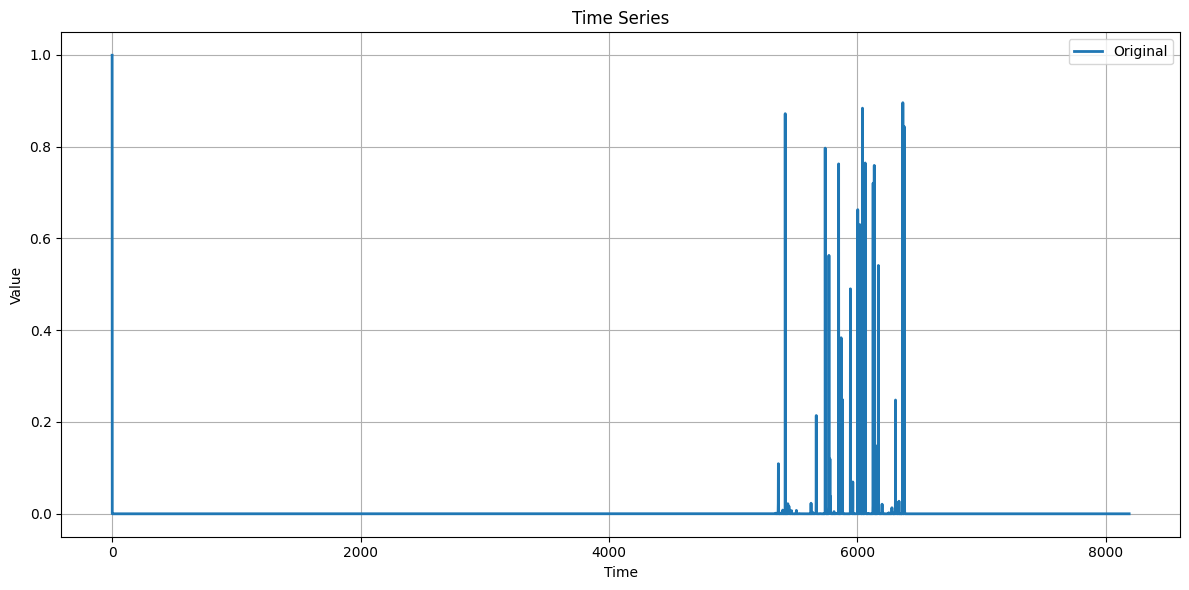

In [15]:
bocpd(test[0], hazard_function, sparsity=10, Nw=20)

The BOCPD model successfully identifies most anomalies in the range `[5350, 6575]`, with no false positive outside the range.

# 3 Self-trained Machine Learning models

## LSTM Auto-Encoder

A LSTM model with `hidden_dim=64` and `num_layers=3` is fitted to the time series. Due to the limitation on computational resources, the model is only trained on `10` epochs.

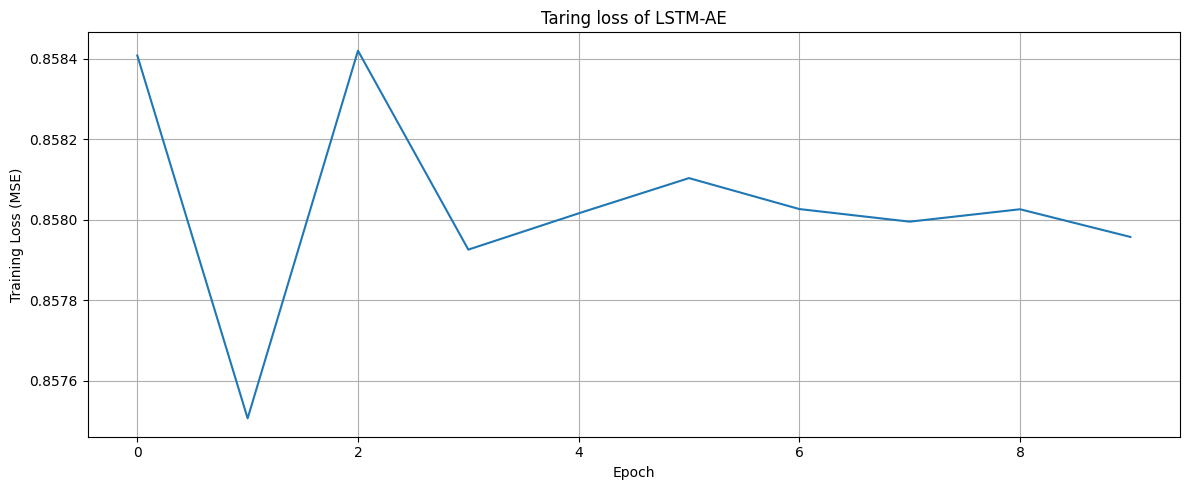

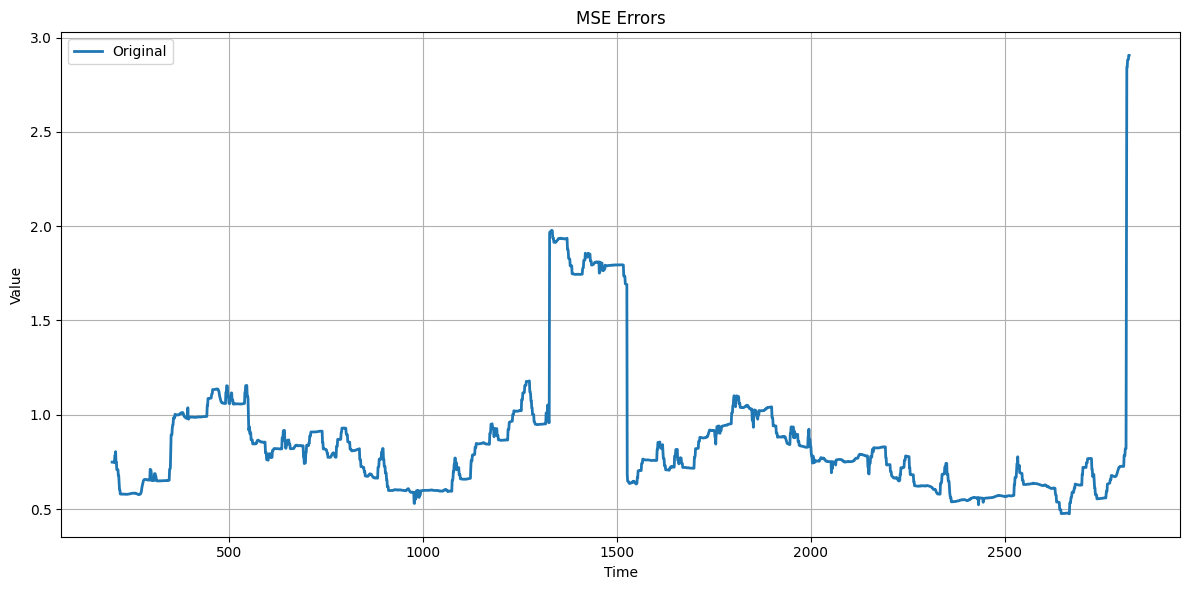

In [ ]:
from src.models.self_trained_ml.lstm_ae import model_LSTMAE
from src.visualization.plots import plot_ts

mse_LSTM, model = model_LSTMAE(df[[0, 'pca1', 'pca2', 'pca3']].rename(columns=str), 
                        window_size=200, batch_size=64, hidden_dim=64, num_layers=3, latent_dim=64, 
                        learning_rate=0.01, epochs=10, plot_accuracy=True)

errors_ts = pd.Series(mse_LSTM.numpy(), index=df.index[200:])
plot_ts(errors_ts, title='MSE Errors')

As indicated by the training loss curve, the LSTM does not appear to fit the data well, showing no clear downward trend in loss. This suggests that key hyperparameters (such as `window_size`, `batch_size`, `hidden_dim`, `num_layers`, and `learning_rate`) may require fine-tuning. Additionally, the model may need to be trained for more `epochs` to capture and learn the underlying patterns in the dataset more effectively.

### Evaluation


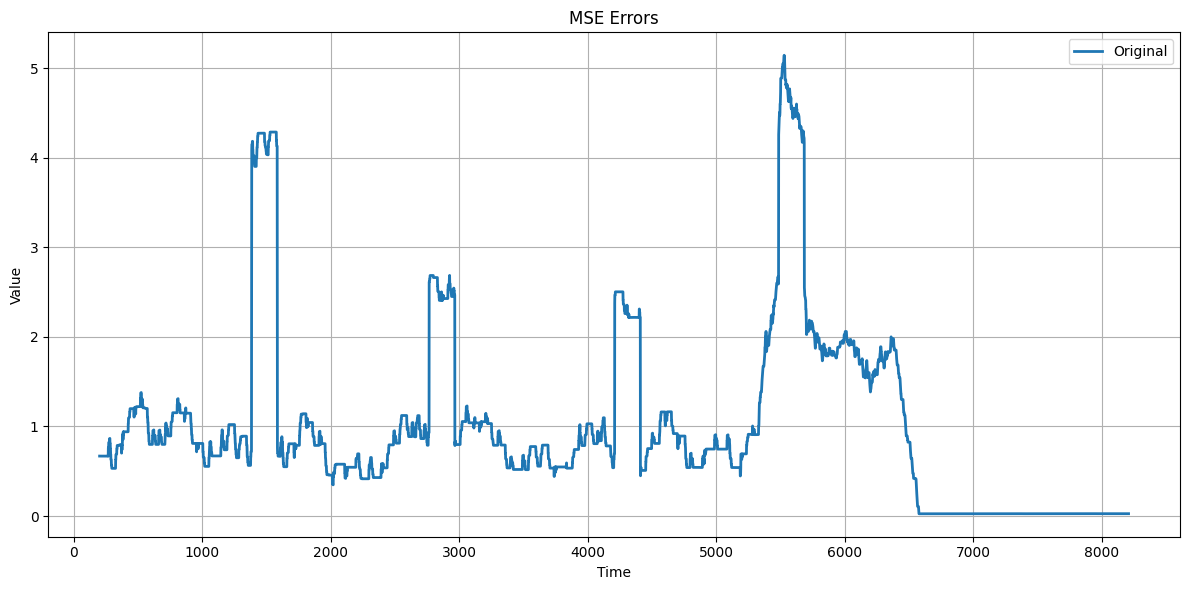

In [27]:
from src.models.preprocessing import create_sliding_windows, standardize_ts
from src.models.self_trained_ml.lstm_ae import eval_LSTMAE
import torch

mse_LSTM = eval_LSTMAE(model, test_data=torch.tensor(
        create_sliding_windows(standardize_ts(test[[0, 'pca1', 'pca2', 'pca3']].rename(columns=str)), window_size=200), dtype=torch.float32))
errors_ts = pd.Series(mse_LSTM.numpy(), index=test.index[200:])
plot_ts(errors_ts, title='MSE Errors')

The MSE peaks when the LSTM the first few anomalies of the anomalous range `[5350, 6575]`, indicating some amount of successful identification of anomalies. 

## Isolation Forest

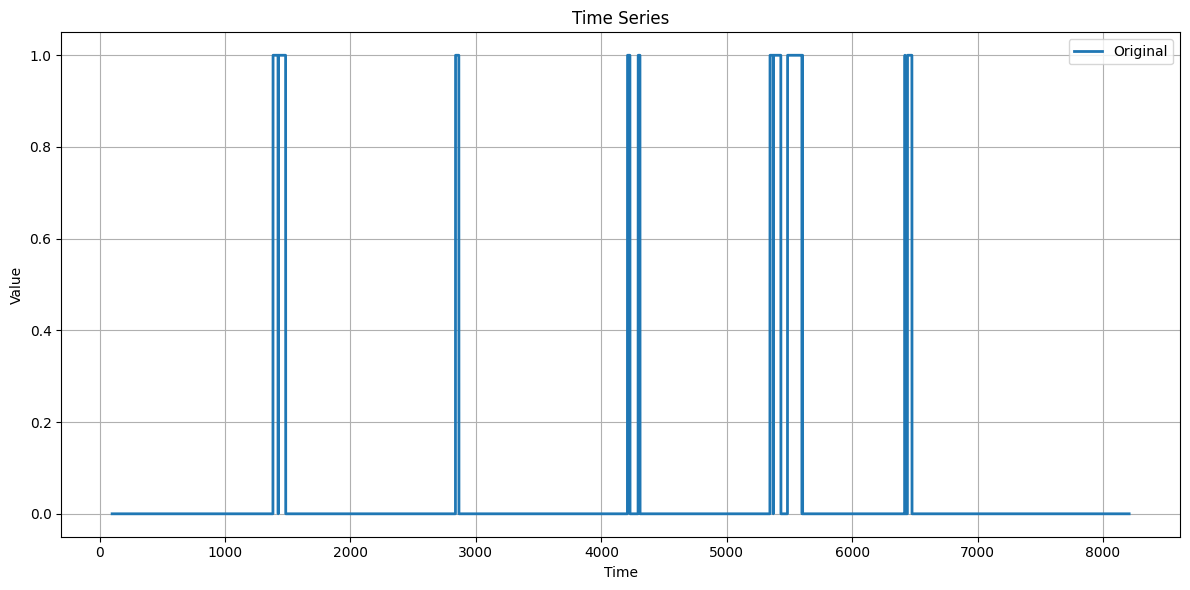

In [31]:
from src.models.self_trained_ml.isolation_forest import model_isolation_forest
import numpy as np

def extract_features(windows) -> pd.DataFrame:
    features = []
    for w in windows:
        df_w = pd.DataFrame(w)
        f = {}
        for col in df_w.columns:
            series = df_w[col]
            f[f'mean_{col}'] = series.mean()
            f[f'std_{col}'] = series.std()
            f[f'min_{col}'] = series.min()
            f[f'max_{col}'] = series.max()
            f[f'skew_{col}'] = series.skew()
            f[f'kurt_{col}'] = series.kurt()
            f[f'slope_{col}'] = np.polyfit(np.arange(len(series)), series.values, 1)[0]

        features.append(f)

    return pd.DataFrame(features)

if_results = model_isolation_forest(test[[0, 'pca1', 'pca2', 'pca3']].rename(columns=str), extract_features=extract_features, window_size=100)
plot_ts(if_results['anomaly'])

The Isolation forest successfully identifies earlier and later anomalies of the anomalous range `[5350, 6575]`, with some false positive outside the range.

# 4 Pretrained Models

## AWS Lookout for Metrics

# 5 Summary & Comparisons 

None of the models tested above were perfect in identifying the exact anomalies in the `short_seasonal` dataset. However, most were able to highlight regions of potential concern, offering useful insights into the data's behavior.

Encouragingly, **all models** except Isolation Forest flagged unusual behavior during 2019, which aligns with the known anomalies in the dataset.

The table below summarizes each model’s performance based on two criteria:
- Whether it correctly identified the known anomalies
- Whether it mistakenly flagged normal regions as anomalous


|Model|Anomalies Detected | False Positives|
|-------|-------------------------------|------------------|
|STL + Z-scores| Partially detected | None |
|STL + CUSUM| Partially detected| Some false positives|
|SARIMA + Prediction | Partially detected | None|
|SARIMA + Anomaly count| Partially detected | None |
|LSTM-AE | Largely detected | Some false positives |
|Isolation forest| Not detected | Some false positives |
|Prophet | Largely detected | Some false positives|